#1. Import Libraries

In [37]:
# Data Wrangling
import pandas as pd
import numpy as np
import math

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#2. Import and Read Data

In [38]:
df = pd.read_csv("/content/assignment_raw_data.csv")
genotypes = pd.read_parquet("/content/assignment_genotypes_subsample.parquet.gz").reset_index()

In [39]:
# Join genotypes with df

genotypes = genotypes.rename(columns={"index":"rfid"}).astype({"rfid":int})
df = pd.merge(df, genotypes, on='rfid')

#3. Clean Data

In [40]:
# Based off EDA, remove rows that belong to a "room_box" that does not surpass a frequency count

freq_cnt = 19 

room_box_counts = df['room_box'].value_counts()
df = df[df['room_box'].isin(room_box_counts[room_box_counts >= freq_cnt].index)]

In [41]:
# Based off EDA, remove rows that have a "cued_age" less than a threshold 

threshold = 105 

df = df[df['cued_age'] >= threshold]

#4. Feature Engineering

###Categorical Features

In [42]:
# Covert 'sex' from M/F to 0/1

df['sex'].replace(['M','F'], [0,1],inplace=True)

In [43]:
# Convert 'site' from italy/us to 0/1

df['site'].replace(['italy','us'], [0,1],inplace=True)

In [44]:
# Convert 'room' into a one hot encoding 

room_ohe = pd.get_dummies(df['room'])
df = pd.concat([df,room_ohe],axis=1)

In [45]:
# Convert 'box' into a one hot encoding

box_ohe = pd.get_dummies(df['box'])
df = pd.concat([df,box_ohe],axis=1)

In [46]:
# Convert 'cohort' from C**(italy/us) to **; where ** is of type int ranging between[2,17]

df['cohort_num'] = (df['cohort'].str[1:3]).astype(int)

###Generate Training and Test Dataset

In [47]:
# Split the data into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(df, df, test_size=0.2, random_state=20)

###Normalize Continuous Features

In [48]:
# Z-Score Normalization
# Z-score is a variation of scaling that represents the number of standard deviations away from the mean. 
# Use z-score to ensure your feature distributions have mean = 0 and std = 1. 
# It’s useful when there are a few outliers, but not so extreme that you need clipping.
# Apply the same normalization technique to the test dataset as the training dataset. This means using the mean and standard deviation calculated from the training dataset.

surg_weight_mean = x_train['surgery_weight'].mean()
surg_weight_std = df['surgery_weight'].std()

x_train['surg_weight_norm'] = (x_train['surgery_weight'] - surg_weight_mean)/surg_weight_std
x_test['surg_weight_norm'] = (x_test['surgery_weight'] - surg_weight_mean)/surg_weight_std


###Correlation Between Mutations and Selected Trait 



In [49]:
# correlation between cued_active trait and each mutation

mutations = list(genotypes.columns)[1:]
corr_cuedActive = {}
for i in mutations: 
  corr_cuedActive[i] = x_train['cued_active'].corr(x_train[i])

In [50]:
# only select mutations to be input features if they surpass a given correlation threshold

corr_threshold = 0.055

top_mutations = {k:v for k,v in corr_cuedActive.items() if v > corr_threshold and not math.isnan(v)}
# for k,v in top_mutations.items():
#   print(f'{k} : {v}')
print(f'Total Number of Mutations: {len(mutations)} \nNumber of Mutations that have a correlation greater than {corr_threshold} : {len(top_mutations)}')

Total Number of Mutations: 3000 
Number of Mutations that have a correlation greater than 0.055 : 473


###Feature Selection

In [51]:
# features that will be used as input to the model 

features = ['cued_active', 'sex', 'site', 'surgery_weight', 'cohort_num', 'cued_age']
features.extend(list(room_ohe.columns))
features.extend(list(box_ohe.columns))
features.extend(list(top_mutations.keys()))

# target 

target = 'cued_active'

In [52]:
# Select the all the columns that contain either the "features" or "target"

feat_train = x_train[features]
target_train = y_train[features]
feat_test = x_test[features]
target_test = y_test[features]

# Remove rows that contain null values

feat_train = feat_train.dropna()
target_train = target_train.dropna()
feat_test = feat_test.dropna()
target_test = target_test.dropna()

# Select the feature columns for input and target column for output

feat_train = feat_train[features[1:]]
target_train = target_train[target]
feat_test = feat_test[features[1:]]
target_test = target_test[target]

#5. Model

In [53]:
# Instantiate Linear Regression Model 

model = LinearRegression()

In [54]:
# Train Model 

model.fit(feat_train, target_train)

LinearRegression()

In [55]:
# Run Model on Test Data

y_pred = model.predict(feat_test)

In [56]:
# Measure Error between predicted values and true values

mse = mean_squared_error(target_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 138.53638785599023


###Visualize Model Performance

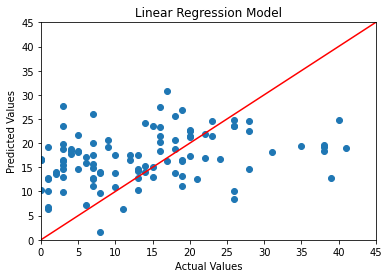

In [57]:
# Plot predicted values against the actual values. 
# Ideally, the points should lie close to a diagonal line with slope=1, indicating a good fit between the predicted and actual values.

plt.scatter(target_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression Model')
plt.plot([0, 45], [0, 45], color='red')
plt.xlim(0, 45)
plt.ylim(0, 45)
plt.show()

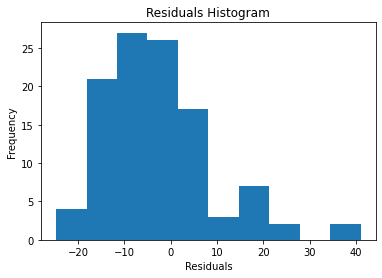

In [58]:
# Plot the residuals. The residuals are the differences between the predicted values and the actual values. 
# Ideally, the residuals should be normally distributed. 

residuals = target_test - y_pred
plt.hist(residuals, bins=10)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()